## Pipeline steps
### Transformers
- **'transformer:standard_scaler'** - scaling to zero mean and unit variance
- **'transformer:power_transformer'** - power transform with Yeo-Johnson algorithm

### Samplers
- **'sampler:ros'** - random over sampling
- **'sampler:smote'** - SMOTE oversampling

### Selectors
- **'selector:remove_correlated'** - remove correlated features based on correlation matrix
- **'selector:remove_nonnormal'** - remove features with large skewness and kurtosis
- **'selector:from_correlated2pca'** - select features most correlated to principal components
- **'selector:sfm_lr'** - select features based on weights from logistic regression model
- **'selector:sfm_et'** - select features based on importances from extra-trees model
- **'selector:sfm_gb'** - select features based on importances from gradient-boosting (scikit-learn) model
- **'selector:sfm_xgb'** - select features based on importances from gradient-boosting (xgboost) model

### Classifiers
- **'classifier:lr'** - logistic regression classifier
- **'classifier:dt'** - decision tree classifier
- **'classifier:et'** - extra-trees classifier
- **'classifier:gb'** - gradient boosting classifier (scikit-learn)
- **'classifier:xgb'** - gradient boosting classifier (xgboost)

## Hyperparameter space
### Transformers
- 'transformer:standard_scaler': {},
- 'transformer:power_transformer': {},

### Samplers
- 'sampler:ros': {},
- 'sampler:smote': {
    'k_neighbors': range(1, 11),
    },

### Selectors
- 'selector:remove_correlated': {
    'threshold': uniform(),
    'score_func': ['f-score', 'h-score'],
    },
- 'selector:remove_nonnormal': {
    'skew_threshold': np.logspace(0, 2, 20, base=100),
    'kurt_threshold': np.logspace(0, 2, 20, base=100)
    },
- 'selector:from_correlated2pca': {
    'n_components': 1.5 - np.logspace(-1, 0, 100, base=2),
    },
- 'selector:sfm_lr': {
    'estimator__penalty': ['elasticnet'],
    'estimator__C': np.logspace(-4, 10, 1000, base=2),
    'estimator__l1_ratio': uniform(),
    'estimator__class_weight': [None, 'balanced'],
    },
- 'selector:sfm_et': {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__criterion': ["gini", "entropy"],
    'estimator__max_features': np.arange(0.05, 1.01, 0.05),
    'estimator__min_samples_split': range(2, 21),
    'estimator__min_samples_leaf': range(1, 21),
    'estimator__bootstrap': [True, False],
    'estimator__class_weight': [None, 'balanced'],
    },
- 'selector:sfm_gb': {
    'estimator__n_estimators': [100, 200, 300, 500],
    'estimator__learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
    'estimator__max_depth': range(1, 11),
    'estimator__min_samples_split': range(2, 21),
    'estimator__min_samples_leaf': range(1, 21),
    'estimator__subsample': np.arange(0.05, 1.01, 0.05),
    'estimator__max_features': np.arange(0.05, 1.01, 0.05)
    },
- 'selector:sfm_xgb': {
    'estimator__n_estimators': [100, 200, 300, 500],
    'estimator__max_depth': range(1, 11),
    'estimator__learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
    'estimator__subsample': np.arange(0.05, 1.01, 0.05),
    'estimator__min_child_weight': range(1, 21),
    'estimator__n_jobs': [1]
    },

### Classifiers
- 'classifier:lr': {
    'C': np.logspace(-5, 10, 100, base=2),
    'penalty': ['elasticnet'],
    'l1_ratio': uniform(),
    'class_weight': [None, 'balanced'],
    },
- 'classifier:dt': {
    'criterion': ["gini", "entropy"],
    'max_depth': range(1, 11),
    'min_samples_split': range(2, 21),
    'min_samples_leaf': range(1, 21)
    },
- 'classifier:et': {
    'n_estimators': [100, 200, 300, 500],
    'criterion': ["gini", "entropy"],
    'max_features': np.arange(0.05, 1.01, 0.05),
    'min_samples_split': range(2, 21),
    'min_samples_leaf': range(1, 21),
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced'],
    },
- 'classifier:gb': {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
    'max_depth': range(1, 11),
    'min_samples_split': range(2, 21),
    'min_samples_leaf': range(1, 21),
    'subsample': np.arange(0.05, 1.01, 0.05),
    'max_features': np.arange(0.05, 1.01, 0.05)
    },
- 'classifier:xgb': {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': range(1, 11),
    'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
    'subsample': np.arange(0.05, 1.01, 0.05),
    'min_child_weight': range(1, 21),
    'n_jobs': [1]
    },

## Imports

In [1]:
import hashlib
import time
from copy import deepcopy
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import interp
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_wine
from joblib import dump, load
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

from ml313.auto_ml import get_pipeline
from ml313.auto_ml import get_param_dist
from ml313.auto_ml import get_support
from ml313.auto_ml import get_weights

pd.set_option('display.max_colwidth', 100)

## Read the data

In [2]:
# X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X, y = load_wine(return_X_y=True, as_frame=True)
y = pd.Series(y == 1)

In [3]:
# Let's drop some good features to make the task more difficult
X = X.drop(columns=['alcohol', 'color_intensity', 'proline'])

In [4]:
print('Number of samples: {}'.format(X.shape[0]))
print('Number of features: {}'.format(X.shape[1]))
print('Number of positive samples: {}'.format(y.sum()))
print('Positive class prevalence: {:.1f}%'.format(y.sum()/len(y)*100))

Number of samples: 178
Number of features: 10
Number of positive samples: 71
Positive class prevalence: 39.9%


### Train test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=313)

## Single model

### Model architecture

In [6]:
# Specify the model
template = ['classifier:xgb']
max_features = None

# Generate the pipeline
pipeline = get_pipeline(template)
print(pipeline)

# Generate hyperparamter space
param_dist = get_param_dist(pipeline)
print('')
print(param_dist)

Pipeline(steps=[('classifier:xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, eval_metric='logloss',
                               gamma=None, gpu_id=None, importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=313, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               use_label_encoder=False,
                               validate_parameters=

### Tuning parameters

In [7]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=313)
hyperparam_samples = 10
n_jobs = -2
random_state = 313

### Tuning function

In [8]:
def optimize(df, model_id):
    # train the model
    model_train = RandomizedSearchCV(pipeline, param_distributions=param_dist, scoring='roc_auc',
                                     n_iter=hyperparam_samples, n_jobs=n_jobs, cv=cv, random_state=random_state,
                                     error_score=np.nan, verbose=0)
    start_time = time.time()
    model_train.fit(X_train, y_train)
    auc_train = pd.DataFrame(model_train.cv_results_).loc[model_train.best_index_, 'mean_test_score']
    auc_train_sd = pd.DataFrame(model_train.cv_results_).loc[model_train.best_index_, 'std_test_score']

    # test the model
    auc_test = model_train.score(X_test, y_test)
    y_test_pred = model_train.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_test_pred)
    prec, recall, _ = precision_recall_curve(y_test, y_test_pred)
    auc_scores = roc_auc_score(y_test, y_test_pred)
    curves_testing = {'auc_scores': auc_scores, 'fpr': fpr, 'tpr': tpr,
                      'prec': prec, 'recall': recall}

    # Computing the lower and upper bound of the 95% confidence interval
    n_bootstraps = 1000
    rng_seed = random_state  # control reproducibility
    bootstrapped_scores = []
    rng = np.random.RandomState()
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_test_pred), len(y_test_pred))
        if len(np.unique(np.asarray(y_test)[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        score = roc_auc_score(np.asarray(y_test)[indices], y_test_pred[indices])
        bootstrapped_scores.append(score)
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    auc_test_cil = sorted_scores[int(0.025 * len(sorted_scores))]
    auc_test_ciu = sorted_scores[int(0.975 * len(sorted_scores))]

    # tuning curves
    auc_scores = list()
    fprs = list()
    tprs = list()
    precs = list()
    recalls = list()
    for train_index, test_index in cv.split(X_train, y_train):
        X_train_temp = X_train.iloc[train_index, :]
        y_train_temp = y_train.iloc[train_index]
        X_test_temp = X_train.iloc[test_index, :]
        y_test_temp = y_train.iloc[test_index]
        model_temp = deepcopy(model_train.best_estimator_)
        model_temp.fit(X_train_temp, y_train_temp)
        # predict on the test split
        y_pred = model_temp.predict_proba(X_test_temp)[:, 1]
        # evalute the performance
        roc_auc = roc_auc_score(y_test_temp, y_pred)
        auc_scores.append(roc_auc)
        #  calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test_temp, y_pred)
        fprs.append(fpr)
        tprs.append(tpr)
        # calculate PR curve
        prec, recall, _ = precision_recall_curve(y_test_temp, y_pred)
        precs.append(prec)
        recalls.append(recall)
    curves_tuning = {'auc_scores': auc_scores, 'fprs': fprs, 'tprs': tprs,
                     'precs': precs, 'recalls': recalls}

    # save the results
    exec_time = time.time()-start_time
    current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    df.loc[model_id, 'pipeline'] = '-'.join(template)
    df.loc[model_id, 'max_features'] = max_features
    df.loc[model_id, 'hyperparam_samples'] = hyperparam_samples
    df.loc[model_id, 'cv'] = cv
    df.loc[model_id, 'auc_train'] = auc_train
    df.loc[model_id, 'auc_train_sd'] = auc_train_sd
    df.loc[model_id, 'auc_test'] = auc_test
    df.loc[model_id, 'auc_test_cil'] = auc_test_cil
    df.loc[model_id, 'auc_test_ciu'] = auc_test_ciu
    df.loc[model_id, 'curves_tuning'] = [curves_tuning]
    df.loc[model_id, 'curves_testing'] = [curves_testing]
    df.loc[model_id, 'exec_time'] = exec_time
    df.loc[model_id, 'time_stamp'] = current_time
    dump(model_train, 'model_{}.joblib'.format(model_id))
    
    return df

### Tune the model

In [9]:
# Create data frame for the results
results = pd.DataFrame()

# Generate model id
model_id = hashlib.md5('{}-{}-{}'.format(template, max_features, hyperparam_samples).encode('utf-8'))
model_id = model_id.hexdigest()[:8]

# Optimize
results = optimize(results, model_id)

### Show the results

In [10]:
results.round(3)  # .drop(columns=['curves_tuning', 'curves_testing'])

,pipeline,max_features,hyperparam_samples,cv,auc_train,auc_train_sd,auc_test,auc_test_cil,auc_test_ciu,curves_tuning,curves_testing,exec_time,time_stamp
47b70162,classifier:xgb,NaN,10.0,"RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=313)",0.937,0.036,0.898,0.796,0.978,"{'auc_scores': [0.9411764705882353, 0.9411764705882353, 0.875, 0.9875, 0.98125, 0.88823529411764...","{'auc_scores': 0.898, 'fpr': [0.0, 0.0, 0.0, 0.04, 0.04, 0.16, 0.16, 0.2, 0.2, 0.32, 0.32, 0.48,...",4.067,2021-03-24 16:18:43



## Multiple templates

In [11]:
# Specify the model
templates = [
    ['transformer:standard_scaler', 'classifier:lr'],
    ['transformer:standard_scaler', 'classifier:et'],
    ['transformer:standard_scaler', 'classifier:xgb'],
    ]
max_features = None

# Specify tuning parameters
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=313)
hyperparam_samples = 100

# Create data frame for the results
results = pd.DataFrame()

# Iterate over templates
for template in tqdm(templates, desc='Template'):
    # Generate the pipeline
    pipeline = get_pipeline(template)

    # Generate hyperparamter space
    param_dist = get_param_dist(pipeline)
    
    # Generate model id
    model_id = hashlib.md5('{}-{}-{}'.format(template, max_features, hyperparam_samples).encode('utf-8'))
    model_id = model_id.hexdigest()[:8]

    # Optimize
    results = optimize(results, model_id)
    
# Show results
results.round(3)

Template:   0%|          | 0/3 [00:00<?, ?it/s]

,pipeline,max_features,hyperparam_samples,cv,auc_train,auc_train_sd,auc_test,auc_test_cil,auc_test_ciu,curves_tuning,curves_testing,exec_time,time_stamp
0157e4a8,transformer:standard_scaler-classifier:lr,NaN,100.0,"RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=313)",0.891,0.091,0.904,0.789,0.99,"{'auc_scores': [0.9647058823529411, 0.9823529411764705, 0.8011363636363635, 0.91875, 0.80625, 0....","{'auc_scores': 0.904, 'fpr': [0.0, 0.0, 0.0, 0.12, 0.12, 0.32, 0.32, 0.48, 0.48, 0.88, 0.88, 1.0...",4.418,2021-03-24 16:18:48
54403aa7,transformer:standard_scaler-classifier:et,NaN,100.0,"RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=313)",0.988,0.019,0.974,0.923,1.00,"{'auc_scores': [1.0, 1.0, 0.9659090909090909, 1.0, 0.98125, 0.9411764705882353, 1.0, 1.0, 0.9937...","{'auc_scores': 0.974, 'fpr': [0.0, 0.0, 0.0, 0.04, 0.04, 0.2, 0.2, 0.24, 0.24, 1.0], 'tpr': [0.0...",98.943,2021-03-24 16:20:27
520250d7,transformer:standard_scaler-classifier:xgb,NaN,100.0,"RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=313)",0.963,0.029,0.974,0.924,1.00,"{'auc_scores': [0.9705882352941175, 0.9764705882352941, 0.8863636363636364, 0.9875, 0.975, 0.947...","{'auc_scores': 0.974, 'fpr': [0.0, 0.0, 0.0, 0.12, 0.12, 0.4, 0.4, 1.0], 'tpr': [0.0, 0.05, 0.9,...",12.460,2021-03-24 16:20:39


## Feature selection

In [12]:
# Specify the model
templates = [
    ['transformer:standard_scaler', 'selector:from_correlated2pca', 'classifier:lr'],
    ['transformer:standard_scaler', 'selector:sfm_gb', 'classifier:et'],
    ]
max_features = None

# Specify tuning parameters
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=313)
hyperparam_samples = 100

# Create data frame for the results
results = pd.DataFrame()

# Iterate over templates
for template in tqdm(templates, desc='Template'):
    # Generate the pipeline
    pipeline = get_pipeline(template)

    # Generate hyperparamter space
    param_dist = get_param_dist(pipeline)
    
    # Generate model id
    model_id = hashlib.md5('{}-{}-{}'.format(template, max_features, hyperparam_samples).encode('utf-8'))
    model_id = model_id.hexdigest()[:8]

    # Optimize
    results = optimize(results, model_id)
    
# Show results
results.round(3)

Template:   0%|          | 0/2 [00:00<?, ?it/s]

,pipeline,max_features,hyperparam_samples,cv,auc_train,auc_train_sd,auc_test,auc_test_cil,auc_test_ciu,curves_tuning,curves_testing,exec_time,time_stamp
6f0bc61c,transformer:standard_scaler-selector:from_correlated2pca-classifier:lr,NaN,100.0,"RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=313)",0.781,0.092,0.746,0.571,0.898,"{'auc_scores': [0.8352941176470589, 0.7999999999999999, 0.7784090909090908, 0.89375, 0.6625, 0.6...","{'auc_scores': 0.746, 'fpr': [0.0, 0.0, 0.0, 0.04, 0.04, 0.16, 0.16, 0.24, 0.24, 0.48, 0.48, 0.6...",4.546,2021-03-24 16:20:44
82aaf0a9,transformer:standard_scaler-selector:sfm_gb-classifier:et,NaN,100.0,"RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=313)",0.951,0.039,0.916,0.824,0.978,"{'auc_scores': [0.9529411764705882, 0.9941176470588236, 0.9090909090909091, 0.99375, 0.88125, 0....","{'auc_scores': 0.9159999999999999, 'fpr': [0.0, 0.0, 0.0, 0.04, 0.04, 0.08, 0.08, 0.12, 0.12, 0....",139.867,2021-03-24 16:23:04


### Restricted model dimensionality

In [13]:
# Specify the model
templates = [
    ['transformer:standard_scaler', 'selector:from_correlated2pca', 'classifier:lr'],
    ['transformer:standard_scaler', 'selector:sfm_gb', 'classifier:et'],
    ]
max_features = 2

# Specify tuning parameters
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=313)
hyperparam_samples = 100

# Create data frame for the results
results = pd.DataFrame()

# Iterate over templates
for template in tqdm(templates, desc='Template'):
    # Generate the pipeline
    pipeline = get_pipeline(template)

    # Generate hyperparamter space
    param_dist = get_param_dist(pipeline)
    
    # Generate model id
    model_id = hashlib.md5('{}-{}-{}'.format(template, max_features, hyperparam_samples).encode('utf-8'))
    model_id = model_id.hexdigest()[:8]

    # Optimize
    results = optimize(results, model_id)
    
# Show results
results.round(3)

Template:   0%|          | 0/2 [00:00<?, ?it/s]

,pipeline,max_features,hyperparam_samples,cv,auc_train,auc_train_sd,auc_test,auc_test_cil,auc_test_ciu,curves_tuning,curves_testing,exec_time,time_stamp
1753560e,transformer:standard_scaler-selector:from_correlated2pca-classifier:lr,2.0,100.0,"RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=313)",0.781,0.092,0.746,0.597,0.904,"{'auc_scores': [0.8352941176470589, 0.7999999999999999, 0.7784090909090908, 0.89375, 0.6625, 0.6...","{'auc_scores': 0.746, 'fpr': [0.0, 0.0, 0.0, 0.04, 0.04, 0.16, 0.16, 0.24, 0.24, 0.48, 0.48, 0.6...",3.584,2021-03-24 16:23:07
57d8239b,transformer:standard_scaler-selector:sfm_gb-classifier:et,2.0,100.0,"RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=313)",0.951,0.039,0.916,0.826,0.982,"{'auc_scores': [0.9529411764705882, 0.9941176470588236, 0.9090909090909091, 0.99375, 0.88125, 0....","{'auc_scores': 0.9159999999999999, 'fpr': [0.0, 0.0, 0.0, 0.04, 0.04, 0.08, 0.08, 0.12, 0.12, 0....",133.434,2021-03-24 16:25:21


## Model tuning and architecture search

In [14]:
# Specify the model
templates = [
    ['transformer:standard_scaler', 'selector:from_correlated2pca', 'classifier:lr'],
    ['transformer:standard_scaler', 'selector:sfm_gb', 'classifier:et'],
    ]
max_features_list = [2, 5]

# Specify tuning parameters
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=313)
hyperparam_samples_list = [30, 100]

# Create data frame for the results
results = pd.DataFrame()

# Iterate over templates
for template in tqdm(templates, desc='Template', leave=True):
    # Generate the pipeline
    pipeline = get_pipeline(template)
    
    for max_features in tqdm(max_features_list, desc='Maximum features', leave=False):
        # Generate hyperparamter space
        param_dist = get_param_dist(pipeline)
        
        for hyperparam_samples in tqdm(hyperparam_samples_list, desc='Hyperparamter samples', leave=False):    
            # Generate model id
            model_id = hashlib.md5('{}-{}-{}'.format(template, max_features, hyperparam_samples).encode('utf-8'))
            model_id = model_id.hexdigest()[:8]
            # Optimize
            results = optimize(results, model_id)
    
# Show results
results.round(3)

Template:   0%|          | 0/2 [00:00<?, ?it/s]

Maximum features:   0%|          | 0/2 [00:00<?, ?it/s]

Hyperparamter samples:   0%|          | 0/2 [00:00<?, ?it/s]

Hyperparamter samples:   0%|          | 0/2 [00:00<?, ?it/s]

Maximum features:   0%|          | 0/2 [00:00<?, ?it/s]

Hyperparamter samples:   0%|          | 0/2 [00:00<?, ?it/s]

Hyperparamter samples:   0%|          | 0/2 [00:00<?, ?it/s]

,pipeline,max_features,hyperparam_samples,cv,auc_train,auc_train_sd,auc_test,auc_test_cil,auc_test_ciu,curves_tuning,curves_testing,exec_time,time_stamp
16e52e2a,transformer:standard_scaler-selector:from_correlated2pca-classifier:lr,2.0,30.0,"RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=313)",0.781,0.092,0.746,0.576,0.893,"{'auc_scores': [0.8352941176470589, 0.7999999999999999, 0.7784090909090908, 0.89375, 0.6625, 0.6...","{'auc_scores': 0.746, 'fpr': [0.0, 0.0, 0.0, 0.04, 0.04, 0.16, 0.16, 0.24, 0.24, 0.48, 0.48, 0.6...",1.745,2021-03-24 16:25:23
1753560e,transformer:standard_scaler-selector:from_correlated2pca-classifier:lr,2.0,100.0,"RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=313)",0.781,0.092,0.746,0.578,0.899,"{'auc_scores': [0.8352941176470589, 0.7999999999999999, 0.7784090909090908, 0.89375, 0.6625, 0.6...","{'auc_scores': 0.746, 'fpr': [0.0, 0.0, 0.0, 0.04, 0.04, 0.16, 0.16, 0.24, 0.24, 0.48, 0.48, 0.6...",3.378,2021-03-24 16:25:26
d4a65d36,transformer:standard_scaler-selector:from_correlated2pca-classifier:lr,5.0,30.0,"RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=313)",0.781,0.092,0.746,0.571,0.884,"{'auc_scores': [0.8352941176470589, 0.7999999999999999, 0.7784090909090908, 0.89375, 0.6625, 0.6...","{'auc_scores': 0.746, 'fpr': [0.0, 0.0, 0.0, 0.04, 0.04, 0.16, 0.16, 0.24, 0.24, 0.48, 0.48, 0.6...",1.754,2021-03-24 16:25:28
c13f503a,transformer:standard_scaler-selector:from_correlated2pca-classifier:lr,5.0,100.0,"RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=313)",0.781,0.092,0.746,0.571,0.899,"{'auc_scores': [0.8352941176470589, 0.7999999999999999, 0.7784090909090908, 0.89375, 0.6625, 0.6...","{'auc_scores': 0.746, 'fpr': [0.0, 0.0, 0.0, 0.04, 0.04, 0.16, 0.16, 0.24, 0.24, 0.48, 0.48, 0.6...",4.026,2021-03-24 16:25:32
be388596,transformer:standard_scaler-selector:sfm_gb-classifier:et,2.0,30.0,"RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=313)",0.951,0.039,0.916,0.840,0.980,"{'auc_scores': [0.9529411764705882, 0.9941176470588236, 0.9090909090909091, 0.99375, 0.88125, 0....","{'auc_scores': 0.9159999999999999, 'fpr': [0.0, 0.0, 0.0, 0.04, 0.04, 0.08, 0.08, 0.12, 0.12, 0....",36.679,2021-03-24 16:26:09
57d8239b,transformer:standard_scaler-selector:sfm_gb-classifier:et,2.0,100.0,"RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=313)",0.951,0.039,0.916,0.824,0.978,"{'auc_scores': [0.9529411764705882, 0.9941176470588236, 0.9090909090909091, 0.99375, 0.88125, 0....","{'auc_scores': 0.9159999999999999, 'fpr': [0.0, 0.0, 0.0, 0.04, 0.04, 0.08, 0.08, 0.12, 0.12, 0....",124.360,2021-03-24 16:28:13
f5686bc8,transformer:standard_scaler-selector:sfm_gb-classifier:et,5.0,30.0,"RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=313)",0.951,0.039,0.916,0.834,0.978,"{'auc_scores': [0.9529411764705882, 0.9941176470588236, 0.9090909090909091, 0.99375, 0.88125, 0....","{'auc_scores': 0.9159999999999999, 'fpr': [0.0, 0.0, 0.0, 0.04, 0.04, 0.08, 0.08, 0.12, 0.12, 0....",37.936,2021-03-24 16:28:51
d7487420,transformer:standard_scaler-selector:sfm_gb-classifier:et,5.0,100.0,"RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=313)",0.951,0.039,0.916,0.818,0.978,"{'auc_scores': [0.9529411764705882, 0.9941176470588236, 0.9090909090909091, 0.99375, 0.88125, 0....","{'auc_scores': 0.9159999999999999, 'fpr': [0.0, 0.0, 0.0, 0.04, 0.04, 0.08, 0.08, 0.12, 0.12, 0....",124.675,2021-03-24 16:30:56


## Model inspection

### ROC curves

In [15]:
def read_roc_data(df, model_id, step='curves_tuning'):
    data = df.loc[model_id]
    try:
        auc_scores = data[step]['auc_scores']
    except TypeError:
        auc_scores = eval(data[step])['auc_scores']
    mean_auc = np.mean(auc_scores)
    try:
        std_auc = np.std(auc_scores)
        try:
            fprs = data[step]['fprs']
            tprs = data[step]['tprs']
        except TypeError:
            fprs = eval(data[step])['fprs']
            tprs = eval(data[step])['tprs']
        mean_fpr = np.linspace(0, 1, 100)
        tprs2 = list()
        for i in range(len(tprs)):
            tprs2.append(interp(mean_fpr, fprs[i], tprs[i]))
            tprs2[-1][0] = 0.0
        mean_tpr = np.mean(tprs2, axis=0)
        mean_tpr[-1] = 1.0
        std_tpr = np.std(tprs2, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        j_index = mean_tpr - mean_fpr
        out = {'mean_fpr': mean_fpr,
               'mean_tpr': mean_tpr,
               # 'mean_auc': mean_auc,
               'std_auc': std_auc, 
               'std_tpr': std_tpr,
               'tprs_lower': tprs_lower,
               'tprs_upper': tprs_upper,
               'j_index': j_index}
    except KeyError:
        out = {'mean_fpr': data[step]['fpr'],
               'mean_tpr': data[step]['tpr'],
               # 'mean_auc': np.nan,
               'std_auc': np.nan, 
               'std_tpr': np.nan,
               'tprs_lower': np.nan,
               'tprs_upper': np.nan,
               'j_index': np.nan}
    out['mean_auc'] = mean_auc
    return out
    
    
def plot_roc_curves(df, model_id, path=None):
    roc_data_tuning  = read_roc_data(df, model_id, 'curves_tuning')
    roc_data_testing  = read_roc_data(df, model_id, 'curves_testing')
    aucs = list()
    plt.figure(figsize=(6.4,6.4))
    colors = ['C0', 'C7', 'C8']
    linestyles = ['-.', ':', '-']
    
    # Plot tuning curves
    i = 0
    roc_data = roc_data_tuning
    mean_fpr = roc_data['mean_fpr']
    mean_tpr = roc_data['mean_tpr']
    mean_auc = roc_data['mean_auc']
    std_auc = roc_data['std_auc']
    aucs.append(mean_auc)
    # std_auc = roc_data['std_auc']
    # std_tpr = roc_data['std_tpr']
    tprs_lower = roc_data['tprs_lower']
    tprs_upper = roc_data['tprs_upper']
    # plt.plot(mean_fpr, mean_tpr, alpha=0.8, lw=2, color=colors[i], linestyle=linestyles[i])
    plt.plot(mean_fpr, mean_tpr, color='C0', alpha=0.8,
             label=r'Tuning (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
             lw=2)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='C0', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
            
            
    # Plot testing curve
    i = 1
    roc_data = roc_data_testing
    mean_fpr = roc_data['mean_fpr']
    mean_tpr = roc_data['mean_tpr']
    mean_auc = roc_data['mean_auc']
    aucs.append(mean_auc)
    plt.plot(mean_fpr, mean_tpr, alpha=0.8, lw=2, color='C8', linestyle='-', label='Testing (AUC={:.3f})'.format(mean_auc))
    
    # The rest
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='k', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    
    if path is not None:
        plt.savefig(path)
    plt.show()

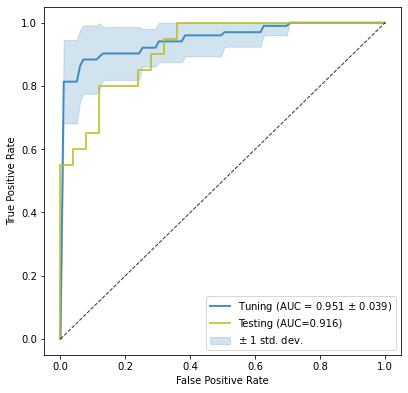

In [16]:
model_id = 'd7487420'
plot_roc_curves(results, model_id, path=None)

### Model weights

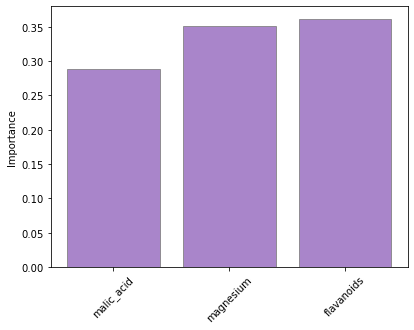

In [17]:
model_id = 'd7487420'

# plot weights
model = load('model_{}.joblib'.format(model_id))
support = get_support(model)
weights = get_weights(model)
plt.figure(figsize=(6.4, 4.8))
plt.bar(range(np.sum(support)), weights,  color="C4", edgecolor='C7', alpha=0.8)
plt.xticks(range(np.sum(support)), X.columns[support], rotation=45)
plt.ylabel('Importance')
plt.show()